In [101]:
import numpy as np
import pretty_midi
import random
from music21 import *
from keras.models import Model, load_model
from keras.layers import Input, Conv2D, BatchNormalization, add
from keras.optimizers import Adam
import keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
class ScoreAnalyzer:
    def __init__(self, fname=None):
        self.fname = fname
        self.roll = None
        self.badData = False
        self.s = corpus.parse(fname)
        self.getPianoRoll()
        
    def getPianoRoll(self):
        parts = list()
        badData = False
        for part in self.s.getElementsByClass(stream.Part):
            if(badData):
                return
            roll = np.zeros(((16*len(part.getElementsByClass(stream.Measure))),128))
            measureNum = 0
            for measure in part.getElementsByClass(stream.Measure):
                if(badData):
                    return
                for note in measure.notes:
                    onset = int(4*note.offset)
                    pitch = int(note.pitch.ps)
                    duration = int(note.duration.quarterLength*4)
                    for i in range(duration):
                        try:
                            roll[(16*measureNum)+i+onset][pitch] = 1
                        except:
                            print("Error with measure", measureNum, "in", self.fname)
                            self.badData = True
                            badData = True
                if(badData):
                    return
                measureNum += 1
            parts.append(roll)
            #print(roll.T)
            #print(roll.shape)
        self.roll = np.array(parts)
            
    def transpose(self, step=None):
        if(not step):
            step = np.random.randint(0,12)
        up = np.random.randint(0,2)
        newroll = self.roll.copy()
        for k in range(self.roll.shape[0]):
            for i in range(self.roll.shape[1]):
                for j in range(self.roll.shape[2]):
                    if(self.roll[k][i][j]==1):
                        newroll[k][i][j] = 0
                        if(up):
                            newj = j+step
                        else:
                            newj = j-step
                        newroll[k][i][newj] = 1
        return newroll[0:4,:,:]
    
    def notFourFour(self):
        time = int(self.s.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure)[0].barDuration.quarterLength)
        return (time != 4)

In [3]:
def makeDataList():
    chorales = list(range(250,439))
    files = list()
    for num in chorales:
        file = "bach/bwv" + str(num) + ".xml"
        SA = ScoreAnalyzer(file)
        if SA.notFourFour():
            continue
        if SA.badData:
            continue
        files.append(file)
    return files

flist = makeDataList()
random.shuffle(flist)
val = flist[0:4].copy()
trn = flist[4:].copy()
len(trn)

163

In [4]:
#Testing Boxes
SA = ScoreAnalyzer('bach/bwv364.xml')
r = SA.roll
tpose = SA.transpose()
print(tpose.shape, r.shape)
np.count_nonzero(tpose)
list(range(64))

(4, 192, 128) (4, 192, 128)


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63]

In [4]:
DEF_LR = .01
DEF_LR_DEC = .01

class ConvNetwork:
    
    def __init__(self, batches=20, num_convs=20, alpha = DEF_LR, alpha_dec = DEF_LR_DEC):
        self.batchSize = batches
        self.nconvs = num_convs
        self.rolls = np.zeros((192,128))
        self.masks = np.zeros((20,4,64,128))
        self.alpha = alpha
        self.alpha_decay = alpha_dec
        self.num_erased = 0
        self.m = self.buildModel()
        
    def TrainModel(self, dataList):
        dlen = len(dataList)*4*8
        self.m.fit_generator(self.batchGenerator(dataList), dlen/self.batchSize, 5)
        return
    
    def batchGenerator(self, dataList):
        while True:
            batchData = random.sample(dataList, self.batchSize)
            self.masks=list()
            batch_x = list()
            batch_y = list()
            self.num_erased = 0
            masks = list()
            for j in range(4):
                mask = np.ones((64,128))
                timeSteps = np.random.randint(20,30)
                self.num_erased += timeSteps
                timeSteps = np.random.choice(a=list(range(64)), size=timeSteps, replace=False)
                for time in timeSteps:
                    mask[time] = np.zeros(128)
                masks.append(mask)
            masks = np.array(masks)
            for fname in batchData:
                SA = ScoreAnalyzer(fname)
                roll = SA.transpose()
                measures = roll.shape[1]//16
                endMeasure=np.random.randint(4,(measures+1))
                yDat = roll[:,(16*endMeasure - 64):endMeasure*16,:]
                ipt = yDat.copy()
                ipt = ipt * masks
                batch_y.append(yDat)
                inst = np.concatenate((ipt, masks.copy()))
                self.masks.append(masks.copy())
                batch_x.append(inst)
            batch_x = np.array(batch_x)
            batch_y = np.array(batch_y)
            self.masks = np.array(self.masks)
            print(batch_x.shape, self.masks.shape, np.count_nonzero(batch_y), np.count_nonzero(self.masks))
            yield(batch_x,batch_y)
        
    def lossFunction(self, y_true, y_pred):
        masks = self.masks
        masks = 1. - masks
        num = np.count_nonzero(masks[:,:,:,0])
        masks = tf.convert_to_tensor(masks, dtype=tf.float32)
        logits = tf.math.log(y_pred)
        unred_err = tf.math.multiply(logits,y_true)
        masks = tf.math.multiply(masks,y_true)
        res = tf.math.multiply(masks, logits)
        print(self.num_erased)
        return -(tf.reduce_sum(res)/num)
        
    def buildModel(self):
        data = Input(shape=(8,64,128))
        preconv = Conv2D(64, 3, padding='same', activation='relu', data_format="channels_first")(data)
        lastInput = BatchNormalization(axis=1)(preconv)
        for i in range(self.nconvs//2):
            conv1 = Conv2D(64, 5, padding='same', activation='relu', data_format="channels_first")(lastInput)
            bn1 = BatchNormalization(axis=1)(conv1)
            conv2 = Conv2D(64, 5, padding='same', activation='relu', data_format="channels_first")(bn1)
            bn2 = BatchNormalization(axis=1)(conv2)
            lastInput = add([lastInput,bn2])
        output = Conv2D(4, 3, padding='same', activation='softmax', data_format="channels_first")(lastInput)
        model = Model(inputs=data, outputs=output)
        model.compile(optimizer="Adam", loss=self.lossFunction)
        return model

In [5]:
network = ConvNetwork()

0


In [6]:
network.TrainModel(flist)


Epoch 1/5
(20, 8, 64, 128) (20, 4, 64, 128) 4640 404480
(20, 8, 64, 128) (20, 4, 64, 128) 4592 381440
(20, 8, 64, 128) (20, 4, 64, 128) 4544 404480
(20, 8, 64, 128) (20, 4, 64, 128) 4490 419840
(20, 8, 64, 128) (20, 4, 64, 128) 4672 386560
(20, 8, 64, 128) (20, 4, 64, 128) 4720 412160
(20, 8, 64, 128) (20, 4, 64, 128) 4432 412160
  1/267 [..............................] - ETA: 2:08:15 - loss: 7.4026(20, 8, 64, 128) (20, 4, 64, 128) 4450 414720
(20, 8, 64, 128) (20, 4, 64, 128) 4608 386560
(20, 8, 64, 128) (20, 4, 64, 128) 4504 414720
(20, 8, 64, 128) (20, 4, 64, 128) 4448 432640
(20, 8, 64, 128) (20, 4, 64, 128) 4318 419840
  2/267 [..............................] - ETA: 1:51:17 - loss: 5.4735(20, 8, 64, 128) (20, 4, 64, 128) 4366 437760
(20, 8, 64, 128) (20, 4, 64, 128) 4336 409600
 64/267 [======>.......................] - ETA: 1:10:29 - loss: 0.5403(20, 8, 64, 128) (20, 4, 64, 128) 4280 404480


135/267 [==============>...............] - ETA: 45:35 - loss: 0.3956(20, 8, 64, 128) (20, 4, 64, 128) 4448 401920


207/267 [======================>.......] - ETA: 20:42 - loss: 0.3445(20, 8, 64, 128) (20, 4, 64, 128) 4288 414720


268/267 [==============================] - 5525s 21s/step - loss: 0.3197
Epoch 2/5
(20, 8, 64, 128) (20, 4, 64, 128) 4592 396800
 11/267 [>.............................] - ETA: 1:27:38 - loss: 0.2299(20, 8, 64, 128) (20, 4, 64, 128) 4864 391680


 82/267 [========>.....................] - ETA: 1:03:20 - loss: 0.2249(20, 8, 64, 128) (20, 4, 64, 128) 4640 394240


154/267 [================>.............] - ETA: 38:41 - loss: 0.2188(20, 8, 64, 128) (20, 4, 64, 128) 4748 424960


226/267 [========================>.....] - ETA: 14:04 - loss: 0.2160(20, 8, 64, 128) (20, 4, 64, 128) 4322 394240


268/267 [==============================] - 5494s 21s/step - loss: 0.2138
Epoch 3/5
(20, 8, 64, 128) (20, 4, 64, 128) 4480 414720
 29/267 [==>...........................] - ETA: 1:21:10 - loss: 0.2133(20, 8, 64, 128) (20, 4, 64, 128) 4516 432640


100/267 [==========>...................] - ETA: 56:55 - loss: 0.2059(20, 8, 64, 128) (20, 4, 64, 128) 4608 422400


172/267 [==================>...........] - ETA: 32:22 - loss: 0.2029(20, 8, 64, 128) (20, 4, 64, 128) 4431 389120


244/267 [==========================>...] - ETA: 7:53 - loss: 0.1998(20, 8, 64, 128) (20, 4, 64, 128) 4416 409600


268/267 [==============================] - 5465s 20s/step - loss: 0.1981
Epoch 4/5
(20, 8, 64, 128) (20, 4, 64, 128) 4316 399360
 47/267 [====>.........................] - ETA: 1:14:38 - loss: 0.1842(20, 8, 64, 128) (20, 4, 64, 128) 4576 417280


118/267 [============>.................] - ETA: 50:31 - loss: 0.1844(20, 8, 64, 128) (20, 4, 64, 128) 4800 381440


190/267 [====================>.........] - ETA: 26:08 - loss: 0.1868(20, 8, 64, 128) (20, 4, 64, 128) 4512 399360


262/267 [============================>.] - ETA: 1:45 - loss: 0.1846(20, 8, 64, 128) (20, 4, 64, 128) 4640 391680


268/267 [==============================] - 5439s 20s/step - loss: 0.1845
Epoch 5/5
(20, 8, 64, 128) (20, 4, 64, 128) 4414 414720
 65/267 [======>.......................] - ETA: 1:08:05 - loss: 0.1793(20, 8, 64, 128) (20, 4, 64, 128) 4608 430080


136/267 [==============>...............] - ETA: 44:09 - loss: 0.1805(20, 8, 64, 128) (20, 4, 64, 128) 4430 419840


208/267 [======================>.......] - ETA: 19:55 - loss: 0.1766(20, 8, 64, 128) (20, 4, 64, 128) 4544 389120


268/267 [==============================] - 5412s 20s/step - loss: 0.1770


In [33]:
output = network.m.predict(batch_x)

In [34]:
output.shape

(20, 4, 64, 128)

In [35]:
output[0][0][0]

array([1.18890489e-06, 5.30707348e-06, 1.18718790e-05, 3.91690946e-06,
       5.33111518e-07, 1.18011178e-06, 5.62210107e-06, 3.83920860e-06,
       4.86079261e-06, 7.20976323e-06, 7.86295368e-06, 8.26014821e-06,
       8.80892912e-06, 9.33955471e-06, 9.37777168e-06, 9.44548356e-06,
       9.54869756e-06, 9.55347969e-06, 9.56118129e-06, 9.56689109e-06,
       9.56917211e-06, 9.57010252e-06, 9.57011252e-06, 9.57023985e-06,
       9.57029442e-06, 9.57030352e-06, 9.57029442e-06, 9.57028533e-06,
       9.57030352e-06, 9.57031261e-06, 9.57032262e-06, 9.57034990e-06,
       9.57043176e-06, 9.57054090e-06, 9.57097927e-06, 9.57151860e-06,
       9.57297016e-06, 9.57579050e-06, 9.57857628e-06, 9.59512545e-06,
       9.59925273e-06, 9.63772345e-06, 9.68128825e-06, 9.70480414e-06,
       1.00042007e-05, 9.82396887e-06, 1.04787350e-05, 1.04097289e-05,
       1.07446976e-05, 1.19516817e-05, 9.08035872e-06, 1.53071196e-05,
       7.70917904e-06, 1.84854234e-05, 2.54521456e-05, 3.73087641e-05,
      

In [36]:
def buildScore(r):
    s = stream.Score()
    for part in r:
        p1 = stream.Part()
        m = stream.Measure()
        lastPitch=None
        currNote = None
        currDuration = 0
        currOnset = 0
        for time in range(part.shape[0]):
            #print(time)
            pitcharr = np.nonzero(part[time])[0]
            if(len(pitcharr) > 0):
                currPitch = pitcharr[0]
            if time == 0:
                currNote = currPitch
                currDuration = 0
                currOnset = 0
            if currPitch != currNote:
                n = note.Note(currNote)
                n.quarterLength = currDuration / 4
                n.onset = currOnset
                print(n.pitch, n.quarterLength, n.onset)
                m.append(n)
                lastPitch = currNote
                currNote = currPitch
                currDuration = 1
                currOnset = (time%16) / 4
            else:
                currDuration += 1
            if time > 0 and (time) % 16 == 0:
                if(currDuration > 1):
                    n = note.Note(currNote)
                    n.quarterLength = (currDuration-1)/4
                    n.onset = currOnset
                    print(n.pitch, n.quarterLength, n.onset)
                    currOnset = 0
                    currDuration = 1
                    m.append(n)
                print("Measure over")
                p1.append(m)
                m = stream.Measure()
        n = note.Note(currNote)
        n.quarterLength = currDuration / 4
        n.onset = currOnset
        m.append(n)
        p1.append(m)
        s.append(p1)
    return s

In [106]:
def sortOnProb(val):
    return val[0]

def sample(b_x, predictions):
    llhd = list()
    sampled = b_x[:,0:4,:,:].copy()
    print(sampled.shape)
    for i in range(len(predictions)):
        for j in range(len(predictions[i])):
            for time in range(len(predictions[i][j])):
                if(b_x[i][j+4][time][0] == 0):
                    pitches = list()
                    for p in range(128):
                        pitch = [predictions[i][j][time][p], p]
                        pitches.append(pitch)
                    pitches.sort(key = sortOnProb, reverse = True)
                    prob = np.random.random()
                    totalProb = 0
                    index = 0
                    for p in range(128):
                        totalProb += pitches[p][0]
                        if totalProb < prob:
                            index = pitches[p][1]
                            llhd.append(-np.log(pitches[p][0]))
                            break
                    sampled[i][j][time][index] = 1
    dat = (np.average(llhd), len(llhd))
    print(dat)
    return (sampled,dat)

In [63]:
smpled = sample(batch_x, output)
print(np.count_nonzero(smpled))

(20, 4, 64, 128)
28.191541077615693
4812


In [62]:
print(np.count_nonzero(batch_x[:,0:4,:,:]))

2652


In [27]:
r = smpled[5]
s = buildScore(r)
s.write('midi', 'test.midi')

E5 1.0 0
C#5 0.25 1.0
C 0.25 1.25
C#5 0.5 1.5
C 0.5 2.0
E-5 0.5 2.5
C#5 1.0 3.0
Measure over
B4 4.0 0.0
Measure over
F#5 2.75 0.0
C9 0.25 2.75
E-9 1.0 3.0
Measure over
F#5 0.75 0.0
C 0.25 0.75
F#5 0.75 1.0
E5 1.0 1.75
C 0.25 2.75
E5 0.5 3.0
C 0.25 3.5
B4 1.0 0
C#5 0.5 1.0
C 0.25 1.5
C#5 0.75 1.75
B4 1.0 2.5
B-4 0.5 3.5
Measure over
F#4 0.5 0.0
C 0.5 0.5
F#4 2.5 1.0
C 0.25 3.5
B4 0.25 3.75
Measure over
B4 0.5 0
C 0.25 0.5
B4 3.25 0.75
Measure over
C#5 0.25 0.0
C 0.25 0.25
F#4 0.5 0.5
B4 1.5 1.0
A4 0.5 2.5
B4 0.5 3.0
G#4 0.25 3.5
G#4 1.0 0
F#4 2.0 1.0
C 0.25 3.0
F#4 0.25 3.25
E4 0.5 3.5
Measure over
E-4 2.5 0.0
F#4 1.5 2.5
Measure over
E-4 3.75 0.0
C 0.25 3.75
Measure over
C#4 0.25 0.0
C 0.25 0.25
C#4 0.25 0.5
C 0.25 0.75
E-4 0.25 1.0
C 0.25 1.25
E-4 0.5 1.5
E4 1.0 2.0
C 0.25 3.0
G#3 1.0 0
B-3 1.0 1.0
B3 1.0 2.0
F#3 0.25 3.0
C 0.25 3.25
F#3 0.5 3.5
Measure over
B2 1.5 0.0
C 0.25 1.5
B2 1.0 1.75
B4 1.25 2.75
Measure over
C 0.25 0.0
B3 3.5 0.25
B-3 0.25 3.75
Measure over
C 0.25 0.0
B-3 0.7

'test.midi'

In [28]:
alpha_min = .02
alpha_max = .8
N = 64*4
nu = .8
for n in range(N):
    prob = max(alpha_min, (alpha_max - (n*(alpha_max-alpha_min)/(nu*N))))
    print(prob)

0.8
0.7961914062500001
0.7923828125000001
0.78857421875
0.784765625
0.78095703125
0.7771484375000001
0.7733398437500001
0.76953125
0.76572265625
0.7619140625
0.7581054687500001
0.7542968750000001
0.75048828125
0.7466796875
0.74287109375
0.7390625000000001
0.7352539062500001
0.7314453125
0.72763671875
0.723828125
0.7200195312500001
0.7162109375000001
0.71240234375
0.70859375
0.70478515625
0.7009765625000001
0.6971679687500001
0.693359375
0.68955078125
0.6857421875
0.6819335937500001
0.6781250000000001
0.67431640625
0.6705078125
0.66669921875
0.6628906250000001
0.6590820312500001
0.6552734375
0.65146484375
0.64765625
0.6438476562500001
0.6400390625000001
0.63623046875
0.632421875
0.62861328125
0.6248046875000001
0.6209960937500001
0.6171875
0.61337890625
0.6095703125
0.6057617187500001
0.6019531250000001
0.59814453125
0.5943359375
0.59052734375
0.5867187500000001
0.5829101562500001
0.5791015625
0.57529296875
0.571484375
0.5676757812500001
0.5638671875000001
0.56005859375
0.55625
0.552441

In [111]:
batchData = random.sample(flist, 20)
allMasks=list()
batch_x = list()
batch_y = list()
masks = list()
erased = 0
#masks.append(np.ones((64,128)))
for j in range(4):
    mask = np.ones((64,128))
    timeSteps = np.random.randint(8,16)
    end = np.random.randint(40,52)
    erased += end - timeSteps
    for time in range(timeSteps, end):
        mask[time] = np.zeros(128)
    masks.append(mask)
masks = np.array(masks)
for fname in batchData:
    SA = ScoreAnalyzer(fname)
    roll = SA.transpose()
    measures = roll.shape[1]//16
    endMeasure=np.random.randint(4,(measures+1))
    yDat = roll[:,(16*endMeasure - 64):endMeasure*16,:]
    ipt = yDat.copy()
    ipt = ipt * masks
    batch_y.append(yDat)
    inst = np.concatenate((ipt, masks.copy()))
    allMasks.append(masks.copy())
    batch_x.append(inst)
batch_x = np.array(batch_x)
batch_y = np.array(batch_y)
allMasks = np.array(allMasks)
print(batch_x.shape)
for i in range(20):
    print(np.count_nonzero(batch_y[i]), np.count_nonzero(batch_x[i,0:4,:,:]), np.count_nonzero(batch_x[i,4:8,:,0]),
         erased)
    unmask = 1. - allMasks
    print(np.count_nonzero(unmask[i,:,:,0]))

(20, 8, 64, 128)
208 85 114 142
142
192 107 114 142
142
240 98 114 142
142
256 114 114 142
142
256 114 114 142
142
192 59 114 142
142
256 114 114 142
142
192 107 114 142
142
256 114 114 142
142
192 107 114 142
142
240 114 114 142
142
192 107 114 142
142
176 95 114 142
142
208 66 114 142
142
192 101 114 142
142
256 114 114 142
142
256 114 114 142
142
240 98 114 142
142
240 98 114 142
142
256 114 114 142
142


In [112]:
def Gibbs(batch_x, a_min, a_max, nu, N):
    output = network.m.predict(batch_x)
    (preds, nll) = sample(batch_x, output)
    nlls = [nll]
    orig_mask = batch_x[0][4:8].copy()
    print("Orig mask", orig_mask.shape)
    for n in range(N):
        newData = preds.copy()
        prob = max(a_min, (a_max - (n*(a_max-a_min)/(nu*N))))
        print(prob)
        masks = list()
        for i in range(4):
            mask = orig_mask[i].copy()
            for time in range(64):
                if (mask[time][0] == 0):
                    if(prob < np.random.random()):
                        mask[time] = np.ones((128))
            masks.append(mask)
        masks = np.array(masks)
        dats = list()
        for i in range(len(batch_x)):
            data = newData[i][0:4].copy()
            data = data * masks
            newinst = np.concatenate((data, masks.copy()))
            dats.append(newinst)
        newData = np.array(dats)
        output = network.m.predict(newData)
        (preds, nll) = sample(newData, output)
        nlls.append(nll)
        print(np.count_nonzero(masks[:,:,0]), np.count_nonzero(newData[:,0:4,:,:]), np.count_nonzero(preds))
    return (preds, nlls)
(preds, data) = Gibbs(batch_x, .03,.9,.85,(64*4))

(20, 4, 64, 128)
(1.0333189, 987)
Orig mask (4, 64, 128)
0.9
(20, 4, 64, 128)
(2.3628325, 1501)
141 2580 4880
0.8960018382352941
(20, 4, 64, 128)
(1.6470686, 1038)
126 2280 4880
0.8920036764705883
(20, 4, 64, 128)
(1.4003081, 1072)
136 2480 4880
0.8880055147058824
(20, 4, 64, 128)
(1.577475, 977)
125 2260 4880
0.8840073529411765
(20, 4, 64, 128)
(1.651774, 1058)
137 2500 4880
0.8800091911764706
(20, 4, 64, 128)
(1.556002, 1017)
126 2280 4880
0.8760110294117647
(20, 4, 64, 128)
(1.2618945, 952)
127 2300 4880
0.8720128676470589
(20, 4, 64, 128)
(0.93906957, 740)
123 2220 4880
0.868014705882353
(20, 4, 64, 128)
(1.5413122, 961)
134 2440 4880
0.8640165441176471
(20, 4, 64, 128)
(1.2756128, 777)
132 2400 4880
0.8600183823529413
(20, 4, 64, 128)
(1.5197381, 954)
132 2400 4880
0.8560202205882353
(20, 4, 64, 128)
(1.5096332, 1136)
136 2480 4880
0.8520220588235294
(20, 4, 64, 128)
(1.5725902, 1100)
137 2500 4880
0.8480238970588235
(20, 4, 64, 128)
(1.408892, 1039)
132 2400 4880
0.84402573529411

(20, 4, 64, 128)
(1.355981, 527)
198 3720 4880
0.40822610294117645
(20, 4, 64, 128)
(1.3797097, 588)
193 3620 4880
0.4042279411764706
(20, 4, 64, 128)
(1.2854131, 399)
207 3900 4880
0.40022977941176474
(20, 4, 64, 128)
(1.2872673, 456)
201 3780 4880
0.39623161764705883
(20, 4, 64, 128)
(1.5668983, 641)
192 3600 4880
0.3922334558823529
(20, 4, 64, 128)
(1.1919988, 430)
201 3780 4880
0.3882352941176471
(20, 4, 64, 128)
(1.2044848, 417)
204 3840 4880
0.3842371323529412
(20, 4, 64, 128)
(1.2662833, 464)
199 3740 4880
0.3802389705882353
(20, 4, 64, 128)
(1.3350468, 417)
208 3920 4880
0.3762408088235294
(20, 4, 64, 128)
(1.3923583, 462)
201 3780 4880
0.3722426470588235
(20, 4, 64, 128)
(1.3707681, 462)
199 3740 4880
0.3682444852941177
(20, 4, 64, 128)
(1.2760185, 447)
203 3820 4880
0.3642463235294118
(20, 4, 64, 128)
(1.2585288, 406)
209 3940 4880
0.36024816176470587
(20, 4, 64, 128)
(1.5411078, 452)
205 3860 4880
0.35625000000000007
(20, 4, 64, 128)
(1.3586154, 463)
200 3760 4880
0.35225183

(20, 4, 64, 128)
(1.3422937, 39)
249 4740 4880
0.03
(20, 4, 64, 128)
(0.85925186, 34)
250 4760 4880
0.03
(20, 4, 64, 128)
(1.1992116, 36)
252 4800 4880
0.03
(20, 4, 64, 128)
(1.5477806, 19)
253 4820 4880


In [110]:
r = preds[14]
s = buildScore(r)
s.write('midi', 'sample.midi')

B4 2.0 0
E4 1.0 2.0
B4 1.0 3.0
Measure over
C#5 1.0 0.0
E-5 1.0 1.0
E5 1.0 2.0
E-5 1.0 3.0
Measure over
E5 0.5 0.0
E-5 0.5 0.5
C#5 1.0 1.0
B4 2.0 2.0
Measure over
E-4 2.0 0
E4 0.5 2.0
F#4 0.5 2.5
C 0.5 3.0
G#4 0.25 3.5
C 0.25 3.75
Measure over
C 0.25 0
E4 0.25 0.25
C 0.75 0.5
G#4 0.25 1.25
C 0.25 1.5
E-5 0.25 1.75
C 0.25 2.0
E-5 0.25 2.25
C 0.75 2.5
G5 0.25 3.25
C 0.25 3.5
G#5 0.25 3.75
Measure over
G#4 0.25 0.0
C 0.25 0.25
A4 0.25 0.5
C 0.5 0.75
B-4 0.25 1.25
C 1.0 1.5
G#4 0.25 2.5
C 0.25 2.75
G#4 0.25 3.0
C 0.5 3.25
F#4 0.25 3.75
Measure over
F#4 0.25 0
G#4 0.25 0.25
C 0.25 0.5
F#3 2.0 0
B3 1.0 2.0
C 0.25 3.0
D 0.5 3.25
C 0.25 3.75
Measure over
C 0.75 0
G#4 0.25 0.75
C 0.25 1.0
F4 0.25 1.25
C 0.5 1.5
G#4 0.25 2.0
C 1.0 2.25
E-5 0.25 3.25
C 0.25 3.5
F#4 0.25 3.75
Measure over
C 0.5 0.0
F#4 0.25 0.5
C 0.25 0.75
G#4 0.25 1.0
C 0.5 1.25
F#4 0.25 1.75
C 0.5 2.0
D 0.25 2.5
C 0.25 2.75
C#5 0.25 3.0
C 0.25 3.25
C#5 0.25 3.5
C 0.25 3.75
Measure over
F#4 0.25 0.0
E4 0.25 0.25
C 0.25 0.5
B2 2.0

'sample.midi'

<IPython.core.display.Javascript object>


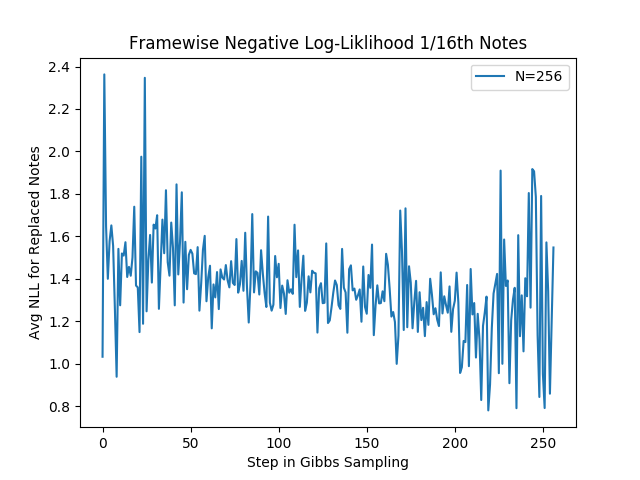

In [120]:
nums = list(zip(*data))[0]
%matplotlib notebook
plt.figure()
plt.title("Framewise Negative Log-Liklihood 1/16th Notes")
plt.xlabel("Step in Gibbs Sampling")
plt.ylabel("Avg NLL for Replaced Notes")
plt.plot(range(len(data)), nums, label="N=256")
plt.legend()
plt.show()

In [46]:
preds.shape

(20, 4, 64, 128)

In [118]:
list(zip(*data))[0]

(1.0333189,
 2.3628325,
 1.6470686,
 1.4003081,
 1.577475,
 1.651774,
 1.556002,
 1.2618945,
 0.93906957,
 1.5413122,
 1.2756128,
 1.5197381,
 1.5096332,
 1.5725902,
 1.408892,
 1.4565532,
 1.4148209,
 1.5009423,
 1.7397586,
 1.368617,
 1.3596804,
 1.1493627,
 1.975258,
 1.1885643,
 2.3467748,
 1.2472584,
 1.4883938,
 1.6067742,
 1.3825519,
 1.6555063,
 1.6371034,
 1.6996838,
 1.2588694,
 1.4707946,
 1.6790843,
 1.5206844,
 1.8174073,
 1.4784151,
 1.4150946,
 1.665106,
 1.5448849,
 1.2753047,
 1.8449739,
 1.4208233,
 1.577752,
 1.8076227,
 1.2883908,
 1.5744883,
 1.3512144,
 1.5128406,
 1.536579,
 1.5187559,
 1.4258645,
 1.4224032,
 1.5494456,
 1.2503631,
 1.3783983,
 1.5370005,
 1.6026314,
 1.294572,
 1.4068505,
 1.4618407,
 1.1670208,
 1.3738915,
 1.3127613,
 1.4320977,
 1.257724,
 1.4445671,
 1.40618,
 1.396978,
 1.4649752,
 1.3938011,
 1.3600844,
 1.4834005,
 1.3808334,
 1.3711994,
 1.587429,
 1.3351308,
 1.3744639,
 1.4846529,
 1.3438541,
 1.6171687,
 1.3610251,
 1.1944429,
 1.376